# SHARK QUEST
## New Kids On The Block



TODO : 
- change df name


In [279]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [280]:
# Import depedencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cleaning import *
from analysis import *


In [281]:
# Settings
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 100)

In [282]:
# Load the data
sources = get_json('sources');

raw_data = load_data(sources['principal'])
df = raw_data.copy()

In [283]:
# Data Contract
data_schema = get_json('schema')

In [284]:
# Rename all columns according to the data schema
df = rename_columns(df, data_schema)

In [285]:
# Add new columns from the data schema
add_columns(df, data_schema)

In [286]:
# Drop columns that are not in the schema
df = drop_columns(df, data_schema)

In [287]:
# Strip strings
df = df.apply(lambda x: x.str.strip() if x.dtype == ['object', 'string'] else x)

In [288]:
# Handling missing values
df = df.replace(['N/A', 'null', '--'], np.nan)

In [289]:
# Remove duplicates
df.drop_duplicates(keep=False, inplace=True)

df = remove_duplicates(df, data_schema)

In [290]:
# Reset Index
df.reset_index(inplace=True)

In [291]:
# Replace values
replacements = get_json('replacements')

df = reformat_values(df, replacements)

In [292]:
# Clean dates
df = clean_dates(df, data_schema)

In [293]:
# Cast correct types
columns_types = {key: value['dtype'] for key, value in data_schema.items()}
df = df.astype(columns_types)

In [294]:
# Validate categories
df = validate_categories(df, data_schema, sources)

In [295]:
# Change case according to the data schema
df = convert_text_case(df, data_schema)    

In [296]:
# Cast correct types
columns_types = {key: value['dtype'] for key, value in data_schema.items()}
df = df.astype(columns_types)

In [297]:
# Clean copy for analysis
shark_attacks_clean = df.copy()
shark_attacks_clean

,index,date,type,country,state,location,activity,sex,severity,time,species,severity_score
0,0,2024-01-03,UNPROVOKED,australia,Queensland,Bargara Beach,SWIMMING,FEMALE,INJURY,AFTERNOON,TIGER SHARK,999
1,1,2024-01-03,UNPROVOKED,united states,Hawaii,"Old Man'S, Waikiki",SURFING,MALE,INJURY,UNKNOWN,TIGER SHARK,999
2,2,2024-01-03,UNPROVOKED,united states,Hawaii,"Rainbows, Oahu",SWIMMING,FEMALE,INJURY,NOON,MYSTERY SHARK,999
3,3,2024-01-02,UNPROVOKED,australia,Western Australia,"Sandlnd Island, Jurian Bay",PASSIVE,FEMALE,INJURY,NOON,TIGER SHARK,999
4,4,2024-01-02,UNPROVOKED,india,Maharashtra,"Vaitarna River, Palghar District",FISHING,MALE,INJURY,UNKNOWN,BULL SHARK,999
...,...,...,...,...,...,...,...,...,...,...,...,...
6800,6939,1913-01-07,UNPROVOKED,australia,Western Australia,Roebuck Bay,DIVING,MALE,FATALITY,UNKNOWN,MYSTERY SHARK,999
6801,6940,1913-01-07,UNPROVOKED,australia,Western Australia,<NA>,DIVING,MALE,FATALITY,UNKNOWN,MYSTERY SHARK,999
6802,6941,1913-01-07,UNPROVOKED,united states,North Carolina,Ocracoke Inlet,SWIMMING,MALE,FATALITY,UNKNOWN,MYSTERY SHARK,999
6803,6942,1913-01-07,UNPROVOKED,panama,<NA>,"Panama Bay 8ºn, 79ºw",PASSIVE,MALE,FATALITY,UNKNOWN,MYSTERY SHARK,999


# ANALYSIS

### Hypothesis: Shark attacks are more concentrated in the PM 

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_70180/3009461686.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Time Category', y='Number of Attacks', data=df_time, palette='Blues')


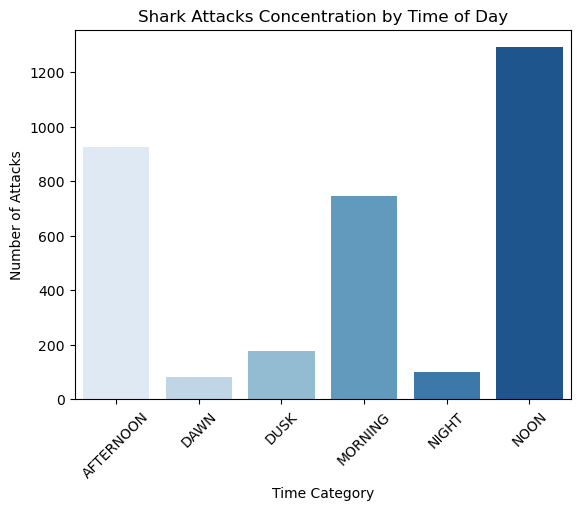

In [298]:
time_stats = shark_attacks_clean['time'].cat.remove_categories('UNKNOWN')

time_counts = time_stats.value_counts()
time_counts


df_time = pd.DataFrame(
    {'Time Category': time_counts.index,
     'Number of Attacks': time_counts.values  
    }
)
df_time

sns.barplot(x='Time Category', y='Number of Attacks', data=df_time, palette='Blues')
plt.title('Shark Attacks Concentration by Time of Day')
plt.xlabel('Time Category')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.show()

#Conclusion: we could easily determine that shark attacks are most concentrated during NOON based on the dataset.

### HYPOTHESIS: SOME SHARK SPECIES ARE MORE DANGEROUS THAN OTHERS

In [299]:
# Add helper columns
shark_attacks_clean['severity_score'] = df['severity'].apply(lambda x: 3 if x == 'FATALITY' else 2 if x == 'INJURY' else 1)

In [300]:
#group by species and severity score, count occurences for each species
species_severity_count = shark_attacks_clean.groupby(['species', 'severity_score']).size().unstack(fill_value=0)

#drop MYSTERY SHARK row
species_severity_count = species_severity_count.drop("MYSTERY SHARK")

#reorder the columns
severity_order = [1, 2, 3]
species_severity_count = species_severity_count[severity_order]


#calculate the percentage
total_counts = species_severity_count.sum(axis=1)

percentage_severity = species_severity_count.div(total_counts, axis=0) * 100


#Filter out low incidence species
species_with_high_counts = total_counts[total_counts > 15].index

filtered_species = percentage_severity.loc[species_with_high_counts]

#convert to string so seaborn correctly filters out dropped species
filtered_species.index = filtered_species.index.astype(str)


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_70180/861426949.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_severity_count = shark_attacks_clean.groupby(['species', 'severity_score']).size().unstack(fill_value=0)


In [301]:
#sort by occurence of FATALITY
sorted_by_category_3 = filtered_species.sort_values(by=3, ascending=False)

top_severity_3 = sorted_by_category_3.head(6)
top_severity_3

severity_score,1,2,3
species,,,
ZAMBEZI SHARK,10.000000,60.000000,30.000000
TIGER SHARK,9.696970,66.666667,23.636364
GREAT WHITE SHARK,17.886179,59.214092,22.899729
BULL SHARK,2.336449,78.504673,19.158879
BLUE SHARK,13.333333,70.000000,16.666667
WHALER SHARK,21.794872,70.512821,7.692308


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_70180/968317060.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_severity_3[3], y=top_severity_3['species'], palette='viridis')


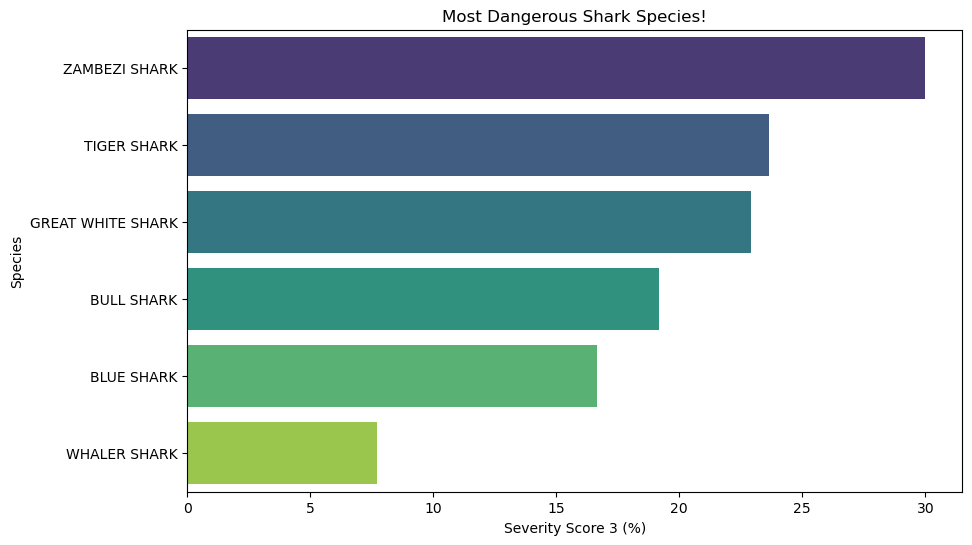

In [302]:
#MOST DANGEROUS SHARK SPECIES VISUALISATION

top_severity_3 = top_severity_3.reset_index()

# Create Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_severity_3[3], y=top_severity_3['species'], palette='viridis')

plt.title('Most Dangerous Shark Species!')
plt.xlabel('Severity Score 3 (%)')
plt.ylabel('Species')

plt.show()

In [303]:
#sort by occurence of NO-INJURY
top_severity_1 = filtered_species.sort_values(by=1, ascending=False)

#filter for lower than 5% fatality rate:
top_severity_1_notdeadly = top_severity_1[top_severity_1[3]<5].head(6)
display(top_severity_1_notdeadly)

severity_score,1,2,3
species,,,
HAMMERHEAD SHARK,22.916667,72.916667,4.166667
MAKO SHARK,22.807018,73.684211,3.508772
SEVENGILL SHARK,18.181818,81.818182,0.000000
NURSE SHARK,10.714286,88.392857,0.892857
RAGGEDTOOTH SHARK,9.302326,90.697674,0.000000
WOBBEGONG SHARK,7.547170,92.452830,0.000000


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_70180/144674034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_severity_1_notdeadly[1], y=top_severity_1_notdeadly['species'], palette='viridis')


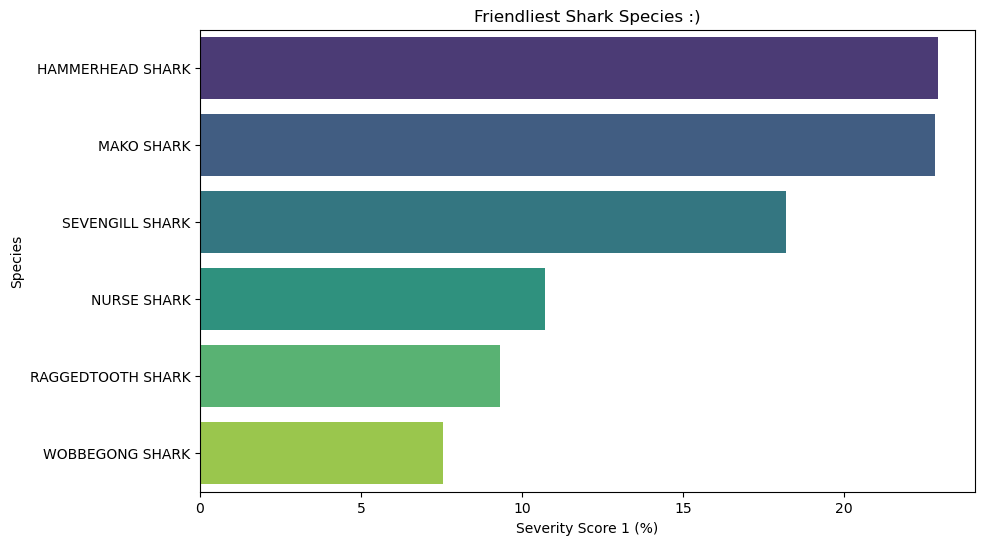

In [304]:
#FRIENDLIEST SHARK SPECIES VISUALISATION

top_severity_1_notdeadly = top_severity_1_notdeadly.reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x=top_severity_1_notdeadly[1], y=top_severity_1_notdeadly['species'], palette='viridis')

plt.title('Friendliest Shark Species :)')
plt.xlabel('Severity Score 1 (%)')
plt.ylabel('Species')

plt.show()

### HYPOTHESIS: SOME COUNTRIES HAVE HIGHER PROVOKED / TOTAL ATTACK RATIO

In [305]:
## working with the clean dataframe instead of main, clearing unused information
sa_clean = shark_attacks_clean[["date", "time", "country", "state", "location", "type", "severity"]].copy()

/Users/jpl/Class/Quests/Shark-Quest/analysis.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/Users/jpl/Class/Quests/Shark-Quest/analysis.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/Users/jpl/Class/Quests/Shark-Quest/analysis.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this

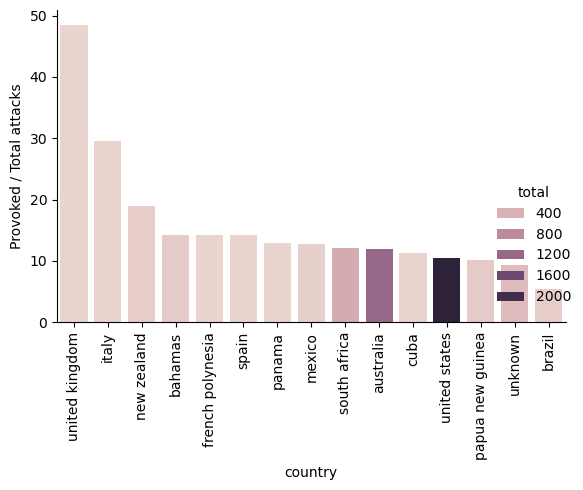

,country,type_x,provoked,type_y,unprovoked,total,ratio
0,united kingdom,PROVOKED,16,UNPROVOKED,17,33,48.48
1,italy,PROVOKED,13,UNPROVOKED,31,44,29.55
2,new zealand,PROVOKED,21,UNPROVOKED,90,111,18.92
3,bahamas,PROVOKED,18,UNPROVOKED,108,126,14.29
4,french polynesia,PROVOKED,5,UNPROVOKED,30,35,14.29
5,spain,PROVOKED,5,UNPROVOKED,30,35,14.29
6,panama,PROVOKED,4,UNPROVOKED,27,31,12.90
7,mexico,PROVOKED,11,UNPROVOKED,75,86,12.79
8,south africa,PROVOKED,57,UNPROVOKED,415,472,12.08
9,australia,PROVOKED,144,UNPROVOKED,1064,1208,11.92


In [306]:
#### whole-time overview  

# unify country, converts all low value "country" ocorrences into <NA>. Also sets Country as string-type
sa_clean["country"] = sa_clean["country"].astype("string")

# this should replace all the bottom part
provoked_sa_country_type = group_and_filter_by_type(sa_clean, ["country", "type"], attack_type="PROVOKED", count_threshold=3)
unprovoked_sa_country_type = group_and_filter_by_type(sa_clean, ["country", "type"], attack_type="UNPROVOKED", count_threshold=4)
watercraft_sa_country_type = group_and_filter_by_type(sa_clean, ["country", "type"], attack_type="WATERCRAFT", count_threshold=0)

clean_merge_and_plot(provoked_sa_country_type, unprovoked_sa_country_type, merge_on="country", provoked_col="count_x", unprovoked_col="count_y", drop_columns=None)

/Users/jpl/Class/Quests/Shark-Quest/analysis.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/Users/jpl/Class/Quests/Shark-Quest/analysis.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/Users/jpl/Class/Quests/Shark-Quest/analysis.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this

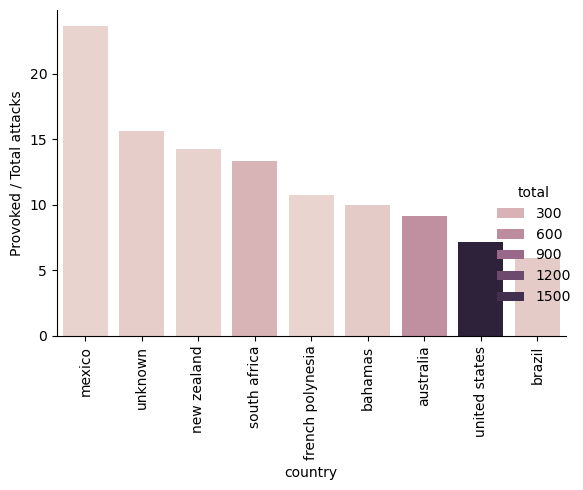

,country,provoked,unprovoked,total,ratio
0,mexico,9,29,38,23.68
1,unknown,13,70,83,15.66
2,new zealand,7,42,49,14.29
3,south africa,38,247,285,13.33
4,french polynesia,3,25,28,10.71
5,bahamas,10,90,100,10.00
6,australia,52,517,569,9.14
7,united states,118,1529,1647,7.16
8,brazil,6,95,101,5.94


In [307]:
###### Lets try to get last 50yrs
date_start = "01-01-1975"
date_start= pd.to_datetime(date_start, format='%d-%m-%Y')
sa_clean["date"] = sa_clean["date"].astype('datetime64[ns]')

# Makes a new database with only last 50yrs score (start jan-1)    
sa_clean_new = sa_clean[sa_clean['date'] > (date_start)].copy()

# Apply the group_and_filter function to get the respective DataFrames
p_sa_country_type_new = group_and_filter_by_type(sa_clean_new, ["country", "type"], attack_type="PROVOKED", count_threshold=2)
up_sa_country_type_new = group_and_filter_by_type(sa_clean_new, ["country", "type"], attack_type="UNPROVOKED", count_threshold=4)
wc_sa_country_type_new = group_and_filter_by_type(sa_clean_new, ["country", "type"], attack_type="WATERCRAFT")

# Plots the info based on clean and merge function
clean_merge_and_plot(p_sa_country_type_new, up_sa_country_type_new, drop_columns=["type_x", "type_y"])

/Users/jpl/Class/Quests/Shark-Quest/analysis.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_70180/1958761944.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = sa_sev.groupby('type')['count'].sum().reset_index(name='total_count')


,type,severity,count,total_count,percentage
0,INVALID,FATALITY,71,594,11.952862
1,INVALID,INJURY,228,594,38.383838
2,INVALID,OTHER,295,594,49.663300
3,PROVOKED,FATALITY,15,630,2.380952
4,PROVOKED,INJURY,540,630,85.714286
5,PROVOKED,OTHER,75,630,11.904762
6,UNPROVOKED,FATALITY,1315,5219,25.196398
7,UNPROVOKED,INJURY,3547,5219,67.963211
8,UNPROVOKED,OTHER,357,5219,6.840391
9,WATERCRAFT,FATALITY,12,362,3.314917


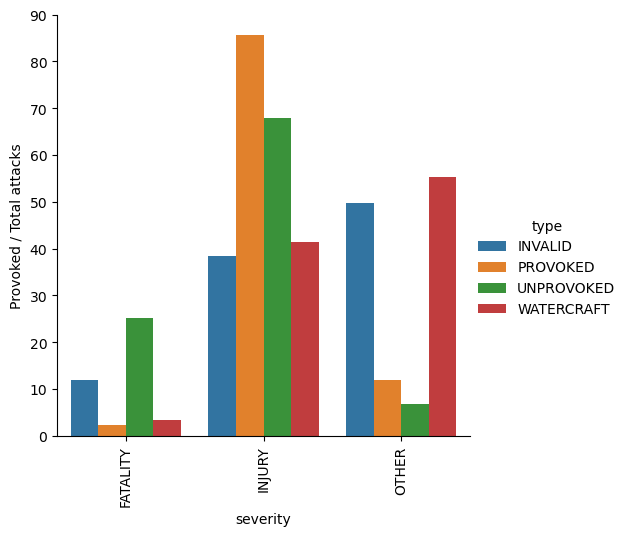

In [308]:
## hipotesis: provoked attack have higher severity than unprovoked attacks // REBUKED

sa_sev = group_and_filter_by_type(sa_clean, ["type","severity"], attack_type=None, count_threshold=0)

#Calculates total counts for each type
total_counts = sa_sev.groupby('type')['count'].sum().reset_index(name='total_count')

#Merge total counts back 
sa_sev = sa_sev.merge(total_counts, on='type')

#Calculate percentage
sa_sev['percentage'] = (sa_sev['count'] / sa_sev['total_count']) * 100

# Display the result
display(sa_sev[['type', 'severity', 'count', 'total_count', 'percentage']])

sns.catplot(data=sa_sev, kind="bar", x="severity", y="percentage",hue="type")
plt.xticks(rotation=90)
plt.ylabel("Provoked / Total attacks")
plt.show()